In [1]:
import os
from PIL import Image, ImageFont, ImageDraw, ImageFont
import numpy as np
import cv2
import random

ImportError: No module named 'cv2'

In [ ]:
PIC_NUM = 600

In [3]:
class TextImageGenerator(object):
    """
    Generate the image that content random text with random noise.
    It also content the boxes of axis of text in each image.
    """
    def __init__(self, img_num, config):
        """
        Generate the images and boxes.
        """
        self.config = config
        self.imgs = []
        self.texts = []
        self.text_list = self.get_text_list()
        self.font_size = self.config['font_size']
        self.font = [ImageFont.truetype('simsun.ttc', self.font_size),
                    ImageFont.truetype('simkai.ttf', self.font_size),
                    ImageFont.truetype('simyuan.ttf', self.font_size)]
        for img_id in range(img_num):
            text = self.text_list[random.randint(0, text_list_len - 1)]
            f = random.randint(0, 2)
            resize_scale = random.random() * 0.6 + 0.4
            self.add_text(text, f, resize_scale)
    
    def add_img(self, img_id):
        """
        Add a image to dataset.
        """
        text = self.text_list[random.randint(0, text_list_len - 1)]
        
        
        # use random image size
        img_size = [int(self.config['size'][0] * (random.random() + 0.5)), 
                    int(self.config['size'][1] * (random.random() + 0.5))]
        img = Image.new('RGB',img_size, self.config['background'])
        text_list_len = len(self.text_list)
        left_axis = random.randint(5, 30)
        top_axis = 1
        boxes = []
        
        # 随机的字体
        f = random.randint(0, 2)
        # 随机大小缩放
        resize_scale = random.random() * 0.6 + 0.4
        
        # 循环生成
        line_height = int(resize_scale * self.font_size) + random.randint(2, 8) 
        
        while True:
            if top_axis >= img_size[1] - line_height:
                break
            text = self.text_list[random.randint(0, text_list_len - 1)]
            text_img, box = self.add_text(img, text, left_axis, top_axis, self.font[f], resize_scale)
            # determine whether box is out of border
            left_axis = box[2] + random.randint(5, 30)
            if box[2] > img_size[0]:
                top_axis += line_height
                left_axis = random.randint(5, 30)
                continue
            img.paste(text_img, (box[0], box[1]))
            boxes.append(box)
        npboxes = np.array(boxes)
        assert (npboxes[:, 2] >= npboxes[:, 0]).all()
        # add blur
        img = np.array(img)
#         img = self.add_blur(img, 0.1)
        img = cv2.cvtColor(img, 6)
        img = cv2.adaptiveThreshold(img, 255,
                                    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                                    thresholdType=cv2.THRESH_BINARY,
                                    blockSize=21,
                                    C=15)
        
        self.boxes.append(boxes)
        self.imgs.append(img)
    
    def add_text(self, text, textfont_type, resize_scale):
        """
        Add a piece of text to image.
        """
        width = len(text)
        text_img = Image.new('RGB', (self.font_size * width, self.font_size), 'white')
        text_draw = ImageDraw.Draw(text_img)
        text_draw.text((0, 0), text, fill=(0, 0, 0), font=font_type)
        text_img = np.array(text_img)
        
        # twist img
        text_img = self.twist_text(text_img, resize_scale)
        
        text_img = Image.fromarray(text_img)
        self.imgs.append(text_img)
        self.texts.append(text)
    
    def get_text_list(self):
        '''
        get the list of all text
        '''
        # get the examine item list
        root_paths = ['./label2label.list', './Nlabel2label.list']
        text_list = []
        for root_path in root_paths:
            with open(root_path, 'r', encoding='utf8') as label_in:
                for line in label_in:
                    line = line.rstrip()
                    text = line.split(',')[0]
                    text_list.append(text.strip('0123456789 .,，-'))
        text_list = list(set(text_list))
        
        item_len = len(text_list)
        text_list = text_list * 15
        # get the random num 
        # without range
        for i in range(int(item_len)):
            for up_num in range(4):
                for down_num in range(3):
                    rand = random.random()
                    rand = round(rand * (10 ** up_num), down_num) 
                    text_list.append(str(rand))
        # with range
        for i in range(int(item_len/2)):
            for up_num in range(4):
                for down_num in range(3):
                    rand1 = random.random()
                    rand1 = round(rand1 * (10 ** up_num), down_num)
                    rand2 = random.random()
                    rand2 = round(rand2 * (10 ** up_num), down_num) 
                    if random.random() < 0.7:
                        text_list.append(str(rand1) + '-' + str(rand2))
                    else:
                        text_list.append(str(rand1) + '--' + str(rand2))
        
        # get the units of examine items
        units_list = ['10^9/L', '10^12/L', '(10^9/L)', '(10^12/L)', 'g/L', '%', 'fL', 'pg', 'fl', 'IU/L', 'μmol/L', 
                      'mmol/L', 'L/L', 'umol/L', 'U/L', '109/L', '1012/L', ]
        for unit in units_list:
            text_list += [unit for _ in range(int(item_len / 4))]
            
        # get the up arrow and down arrow
        arrow_list = ['↑', '↓']
        for arrow in arrow_list:
            text_list += [arrow for _ in range(int(item_len * 3))]
        
        return text_list
    
    def twist_text(self, text_img, resize_scale):
        """
        Add noise to text.
        """
        height, width, rgb = text_img.shape
        reversed_img = 255 - text_img
        # remove the right blank
        shadow = np.sum(np.sum(reversed_img, axis=2), axis=0)
        for i in shadow[::-1]:
            if i == 0:
                width -= 1
            else:
                break
        width += 2
        reversed_img = reversed_img[:, :width, :]
        
        # add bias
        reversed_img = self.add_bias(reversed_img)
        
        # resize
        
        reversed_img = cv2.resize(reversed_img, (int(width * resize_scale), int(height * resize_scale)))
        
        # reverse
        img = 255 - reversed_img
        
        # add blur
        img = self.add_blur(img)
        
        return img
    
    def add_bias(self, img):
        highy, lenx, rgb = img.shape
        
        bp = [random.randint(0, 10) for _ in range(8)]

        transform = cv2.getPerspectiveTransform(np.float32([[-bp[0], -bp[1]], [lenx+bp[2], -bp[3]], [-bp[4], highy+bp[5]], [lenx+bp[6], highy+bp[7]]]),
                                                np.float32([[0, 0], [lenx, 0], [0, highy], [lenx, highy]]))
        bias_img = cv2.warpPerspective(img, transform, (lenx, highy))
        return bias_img
        
    def add_blur(self, src, percetage=0.1):
#         NoiseImg = src
#         NoiseNum = int(percetage*src.shape[0] * src.shape[1])
#         for i in range(NoiseNum):
#             randX = random.randint(0, src.shape[0] - 1)
#             randY = random.randint(0, src.shape[1] - 1)
#             if random.randint(0, 1) == 0:
#                 NoiseImg[randX,randY] = 0
#             else:
#                 NoiseImg[randX,randY] = 255   
        blur_rand = random.randint(0, 1)
        blur_rand = blur_rand * 2 + 1
        NoiseImg = cv2.GaussianBlur(src, (blur_rand, blur_rand), 0)
        NoiseNum = int(percetage*NoiseImg.shape[0] * NoiseImg.shape[1])
        for i in range(NoiseNum):
            randX = random.randint(0, src.shape[0] - 1)
            randY = random.randint(0, src.shape[1] - 1)
            if random.randint(0, 1) == 0:
                NoiseImg[randX,randY] = 255
        return NoiseImg

    def get_texts(self):
        return self.texts
        
    def get_imgs(self):
        return self.imgs

In [4]:
config = {
    'size': (800, 400),
    'background': (255, 255, 255),
    'font_size': 40
}
ttg = TextImageGenerator(PIC_NUM, config)
imgs = ttg.get_imgs()
texts = ttg.get_texts()

NameError: name 'PIC_NUM' is not defined

In [23]:
voc_root_path = './VOCdevkit'
voc2007 = voc_root_path + '/VOC2007'
if not os.path.exists(voc_root_path):
    os.mkdir(voc_root_path)
    os.mkdir(voc2007)
target_path = voc2007 + '/JPEGImages'
if not os.path.exists(target_path):
    os.mkdir(target_path)
# target_box = './train_boxes'
# if not os.path.exists(target_box):
#     os.mkdir(target_box)

In [24]:
# 保存图片
for i, (img, box) in enumerate(zip(imgs, boxes)):
    img_path = os.path.join(target_path, '%06d.jpg' % (i+1))
    
    cv2.imwrite(img_path, np.array(img))
#     box_path = os.path.join(target_box, '%06d.txt' % (i+1))
#     with open(box_path, 'w', encoding='utf8') as box_out:
#         for i in box:
#             box_out.write(' '.join([str(j) for j in i]))
#             box_out.write('\n')

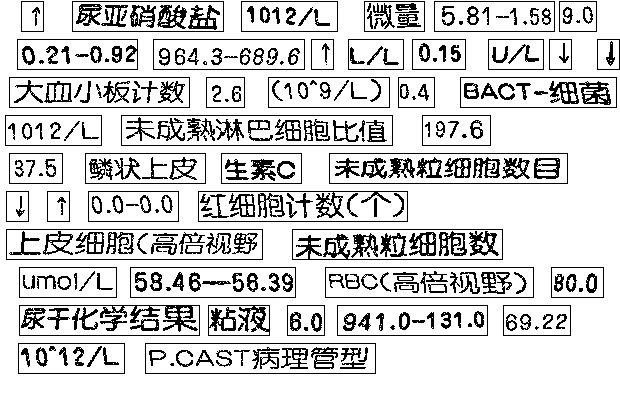

In [25]:
img = np.array(ttg.get_imgs()[0])
for box in ttg.get_boxes()[0]:
    cv2.rectangle(img, tuple(box[:2]), tuple(box[2:]), (0, 0, 0))
Image.fromarray(img)

In [26]:
# 保存为XML
from xml.dom.minidom import Document

In [27]:
def get_xml(img_name, objects_axis, im_height, im_width, save_path):
    object_num = len(objects_axis)
    doc = Document()

    annotation = doc.createElement('annotation')
    doc.appendChild(annotation)

    folder = doc.createElement('folder')
    folder_name = doc.createTextNode('VOC2007')
    folder.appendChild(folder_name)
    annotation.appendChild(folder)

    filename = doc.createElement('filename')
    filename_name = doc.createTextNode(img_name)
    filename.appendChild(filename_name)
    annotation.appendChild(filename)

    source = doc.createElement('source')
    annotation.appendChild(source)

    database = doc.createElement('database')
    database.appendChild(doc.createTextNode('The VOC2007 Database'))
    source.appendChild(database)

    annotation_s = doc.createElement('annotation')
    annotation_s.appendChild(doc.createTextNode('PASCAL VOC2007'))
    source.appendChild(annotation_s)

    image = doc.createElement('image')
    image.appendChild(doc.createTextNode('flickr'))
    source.appendChild(image)

    flickrid = doc.createElement('flickrid')
    flickrid.appendChild(doc.createTextNode('322409915'))
    source.appendChild(flickrid)

    owner = doc.createElement('owner')
    annotation.appendChild(owner)

    flickrid_o = doc.createElement('flickrid')
    flickrid_o.appendChild(doc.createTextNode('knautia'))
    owner.appendChild(flickrid_o)

    name_o = doc.createElement('name')
    name_o.appendChild(doc.createTextNode('yang'))
    owner.appendChild(name_o)


    size = doc.createElement('size')
    annotation.appendChild(size)
    ##需要修改的就是这部分，宽高
    width = doc.createElement('width')
    width.appendChild(doc.createTextNode(str(im_width)))
    height = doc.createElement('height')
    height.appendChild(doc.createTextNode(str(im_height)))
    depth = doc.createElement('depth')
    depth.appendChild(doc.createTextNode(str(3)))
    size.appendChild(width)
    size.appendChild(height)
    size.appendChild(depth)
    segmented = doc.createElement('segmented')
    segmented.appendChild(doc.createTextNode('0'))
    annotation.appendChild(segmented)
    ##需要添加目标
    for i in range(object_num):
        objects = doc.createElement('object')
        annotation.appendChild(objects)
        object_name = doc.createElement('name')
        object_name.appendChild(doc.createTextNode('item'))
        objects.appendChild(object_name)
        pose = doc.createElement('pose')
        pose.appendChild(doc.createTextNode('Unspecified'))
        objects.appendChild(pose)
        truncated = doc.createElement('truncated')
        truncated.appendChild(doc.createTextNode('1'))
        objects.appendChild(truncated)
        difficult = doc.createElement('difficult')
        difficult.appendChild(doc.createTextNode('0'))
        objects.appendChild(difficult)
        bndbox = doc.createElement('bndbox')
        objects.appendChild(bndbox)
        xmin = doc.createElement('xmin')
        xmin.appendChild(doc.createTextNode(str(objects_axis[i][0])))
        bndbox.appendChild(xmin)
        ymin = doc.createElement('ymin')
        ymin.appendChild(doc.createTextNode(str(objects_axis[i][1])))
        bndbox.appendChild(ymin)
        xmax = doc.createElement('xmax')
        xmax.appendChild(doc.createTextNode(str(objects_axis[i][2])))
        bndbox.appendChild(xmax)
        ymax = doc.createElement('ymax')
        ymax.appendChild(doc.createTextNode(str(objects_axis[i][3])))
        bndbox.appendChild(ymax)

    f = open(save_path,'w')
    f.write(doc.toprettyxml(indent = ''))
    f.close() 

In [28]:
# 保存标注xml
xml_path = voc2007 + '/Annotations'
if not os.path.exists(xml_path):
    os.mkdir(xml_path)
for i, box in enumerate(boxes):
    save_path = os.path.join(xml_path, '%06d.xml' % (i+1))
    get_xml('%06d.jpg' % (i+1), box, imgs[i].shape[0], imgs[i].shape[1], save_path=save_path)

In [29]:
# 设定训练集和测试集验证集
imageset_path = voc2007 + '/ImageSets'
main_path = imageset_path + '/Main'
if not os.path.exists(imageset_path):
    os.mkdir(imageset_path)
    os.mkdir(main_path)

def save_txt(filename, datas):
    with open(filename, 'w', encoding='utf8') as output:
        for data in datas:
            output.write('%06d\n' % data)

save_txt(main_path + '/train.txt', [i for i in range(1, int(PIC_NUM / 4) + 2)])
save_txt(main_path + '/val.txt', [i for i in range(int(PIC_NUM / 4) + 2, int(PIC_NUM / 2) + 1)])
save_txt(main_path + '/trainval.txt', [i for i in range(1, int(PIC_NUM / 2) + 1)])
save_txt(main_path + '/test.txt', [i for i in range(int(PIC_NUM / 2 + 1), PIC_NUM + 1)])